# 06_GAN(생성적 적대 신경망, Generative Adversarial Network)

> - MNIST 손글씨 판별하기

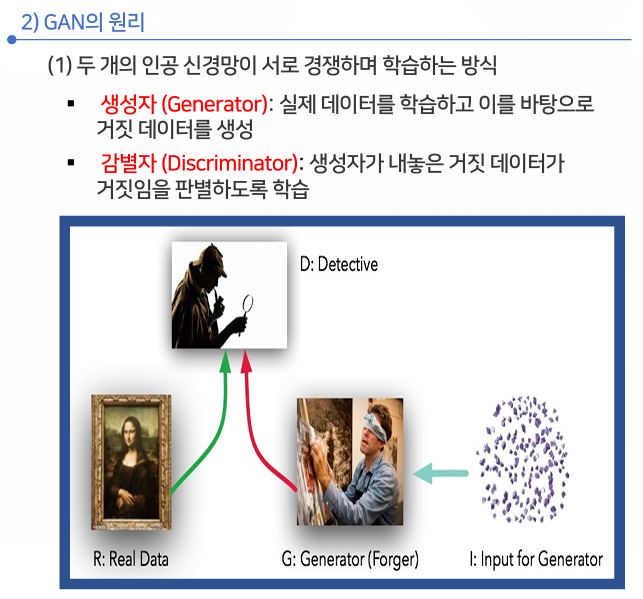

In [1]:
from IPython.display import Image
Image("img/day04_01.png", width=600)

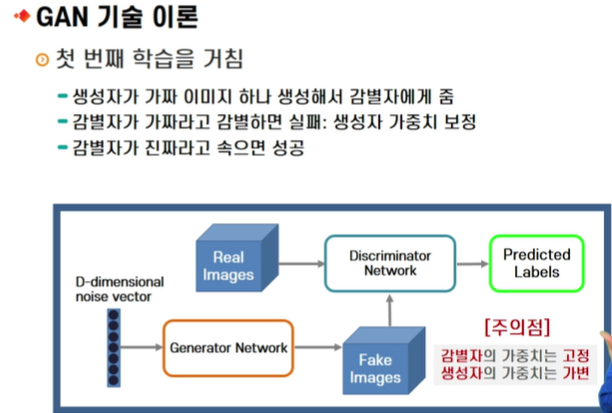

In [2]:
Image("img/day04_02.png", width=600)

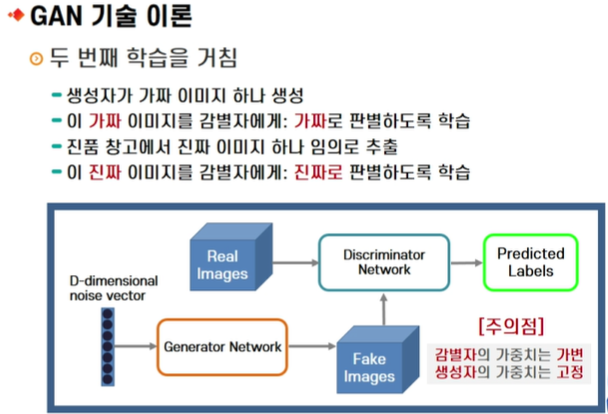

In [3]:
Image("img/day04_03.png", width=600)

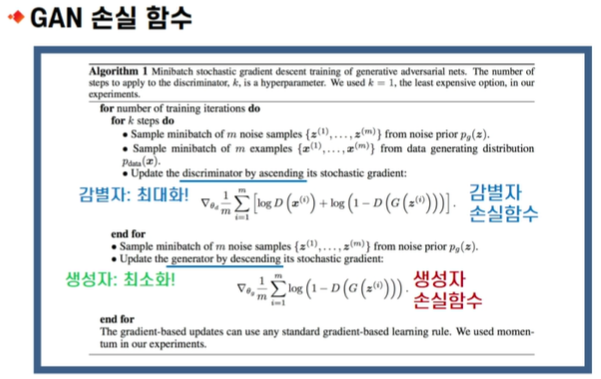

In [4]:
Image("img/day04_04.png", width=600)

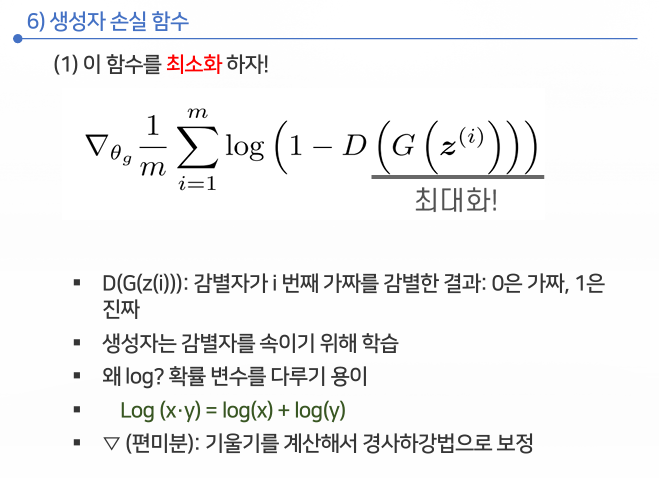

In [5]:
Image("img/day04_05.png", width=600)

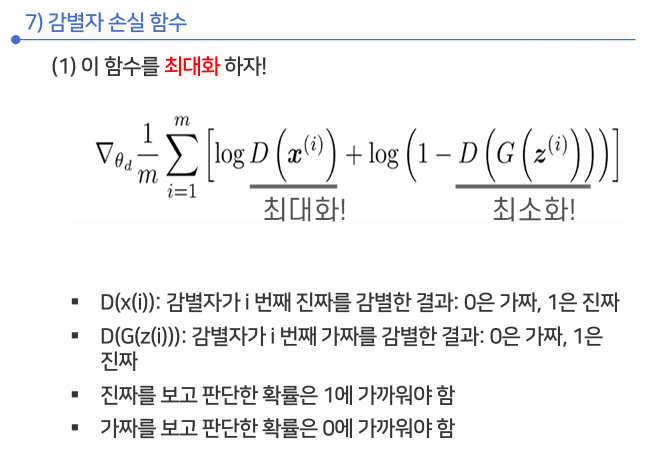

In [6]:
Image("img/day04_06.png", width=600)

### MNIST 손글씨 Dataset

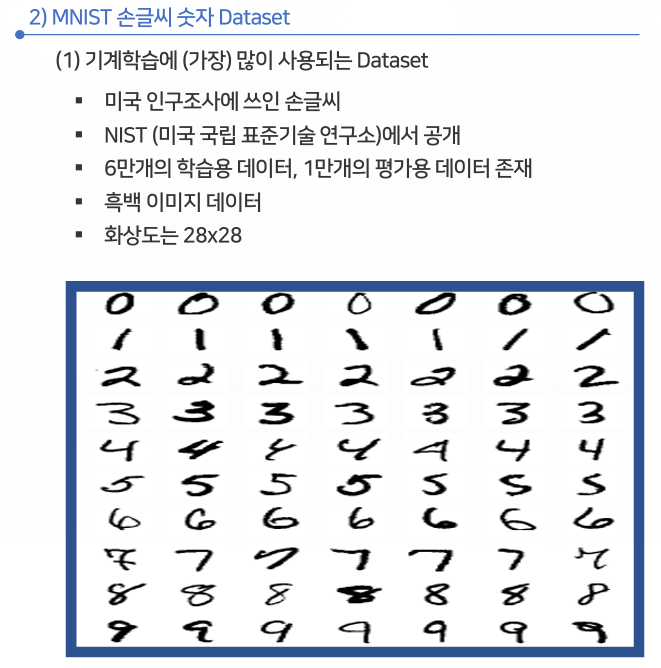

In [7]:
Image("img/day04_07.png", width=600)

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from time import time
import os
import glob

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape, LeakyReLU
from keras.models import Sequential

In [9]:
# 하이퍼 파라미터
MY_GEN = 128
MY_DIS = 128
MY_NOISE = 100

MY_SHAPE = (28,28,1)
MY_EPOCH = 5000
MY_BATCH = 300

# 출력이미지 폴더 생성
MY_FOLDER = 'output/'

# (같은 이름이 있으면 오류 없이 바로 진행 )
os.makedirs(MY_FOLDER, exist_ok=True)

# outpu 폴더에 하나하나 접근하는 해서 삭제하는 
for i in glob.glob(MY_FOLDER + "*"):
    os.remove(i)


### 여기서는 모든 필요한 코딩을 함수로 만들어서 사용

### 01. 데이터 준비

In [10]:
def read_data():
    # 학습용 입력값만 사용 ( GAN은 비지도 학습)
    (X_train, _ ), ( _, _ ) = mnist.load_data()
    
    print("데이터모양-전 : ", X_train.shape)
    # plt.imshow(X_train[0], cmap='gray')
    # plt.show()
    
    # 데이터 스케일[-1, 1]    
    X_train = X_train / 127.5 - 1.0
    
    # 채널 정보 추가 (차원확장) ; 이미지 이므로
    X_train = np.expand_dims(X_train, axis=3)
    print("데이터모양-후 : ", X_train.shape)
    
    return X_train


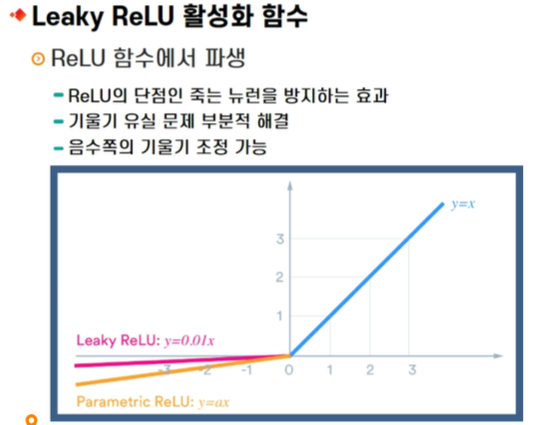

In [11]:
Image("img/day04_08.png", width=600)

> - 음의 기울기 조정 (0.01이면  -1인 경우 -0.01 이 된다. ( 100배 축소))

### 생성자 구현

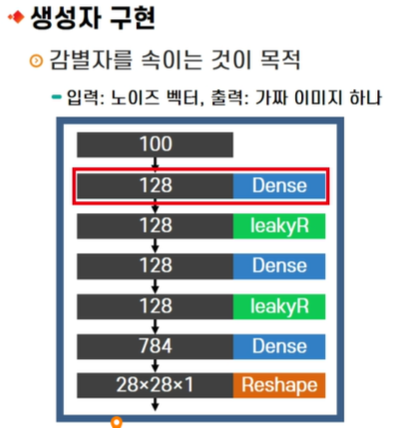

In [12]:
Image("img/day04_09.png", width=400)

In [13]:
#### 인공 신경망 구현 

# 생성자 설계
def build_generator():
    model = Sequential()
    
    # 입력층  + 은닉층 1
    model.add(Dense(MY_GEN, input_dim = MY_NOISE))
    model.add(LeakyReLU(alpha=0.01))
    
    # 은닉층 2
    model.add(Dense(MY_GEN))
    model.add(LeakyReLU(alpha=0.01))
    
    # 은닉층 3 + 출력층
    model.add(Dense(28*28*1, activation='tanh'))
    model.add(Reshape(MY_SHAPE))
    
    print("생성자 요약")
    model.summary()
    
    return model

In [14]:
build_generator()

생성자 요약


C:\Users\ICT05_01\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ICT05_01\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          12,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 784)                 │         101,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,576 (510.06 KB)

 Trainable params: 130,576 (510.06 KB)

 Non-trainable params: 0 (0.00 B)

<Sequential name=sequential, built=True>

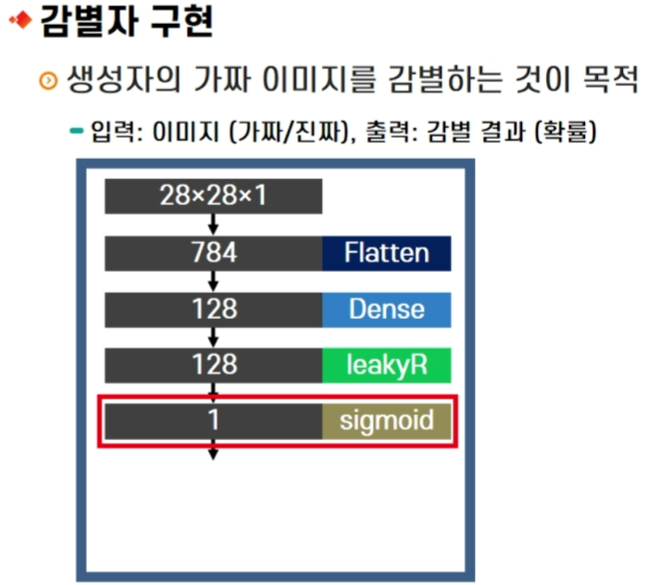

In [15]:
Image("img/day04_13.png", width=400)

In [16]:
### 감별자 설계
def build_discriminator():
    model = Sequential()
    
    # 입력층
    model.add(Flatten(input_shape=MY_SHAPE))
    
    # 은닉층
    model.add(Dense(MY_DIS))
    model.add(LeakyReLU(alpha=0.01))
    
    # 출력층 ( 시그모이드 사용)
    model.add(Dense(1, activation='sigmoid'))
        
    model.summary()
    return model

In [17]:
build_discriminator()

C:\Users\ICT05_01\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,609 (393.00 KB)

 Trainable params: 100,609 (393.00 KB)

 Non-trainable params: 0 (0.00 B)

<Sequential name=sequential_1, built=True>

### DNN-GAN 설계

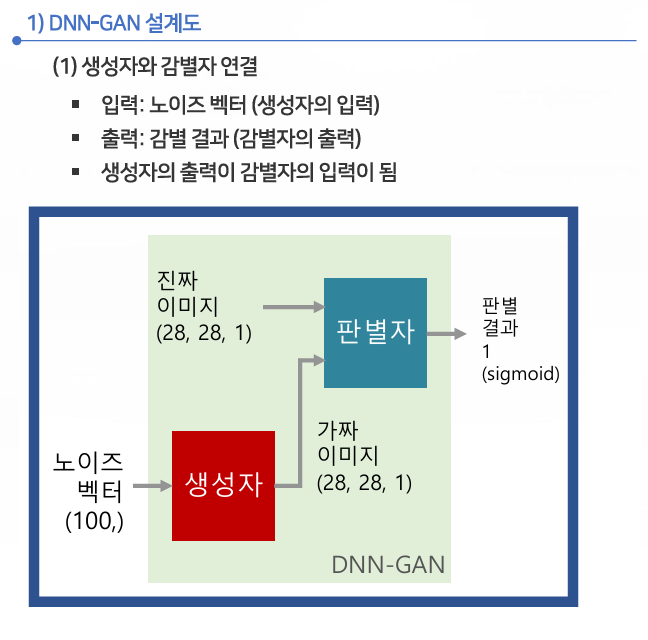

In [18]:
Image("img/day04_16.png", width=600)

In [19]:
def build_GAN():
    model = Sequential()
    
    # 생성자 구현
    generator = build_generator()
    
    # 감별자 구현
    discriminator = build_discriminator()
    
    ## 생성자 학습 시 감별자는 고정
    discriminator.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc'])
    
    discriminator.trainable = False
    
    ##  GAN 구현 : 생성자 먼저 추가, 그 다음 감별자
    model.add(generator)
    model.add(discriminator)
    
    ## GAN 의 컴파일 ( 정확도는 무의미한다.)
    model.compile(optimizer="adam", loss="binary_crossentropy")
        
    return discriminator, generator, model
    

In [20]:
build_GAN()

생성자 요약


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 128)                 │          12,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 784)                 │         101,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,576 (510.06 KB)

 Trainable params: 130,576 (510.06 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,609 (393.00 KB)

 Trainable params: 100,609 (393.00 KB)

 Non-trainable params: 0 (0.00 B)

(<Sequential name=sequential_4, built=True>,
 <Sequential name=sequential_3, built=True>,
 <Sequential name=sequential_2, built=False>)

### 인공 신경망 학습

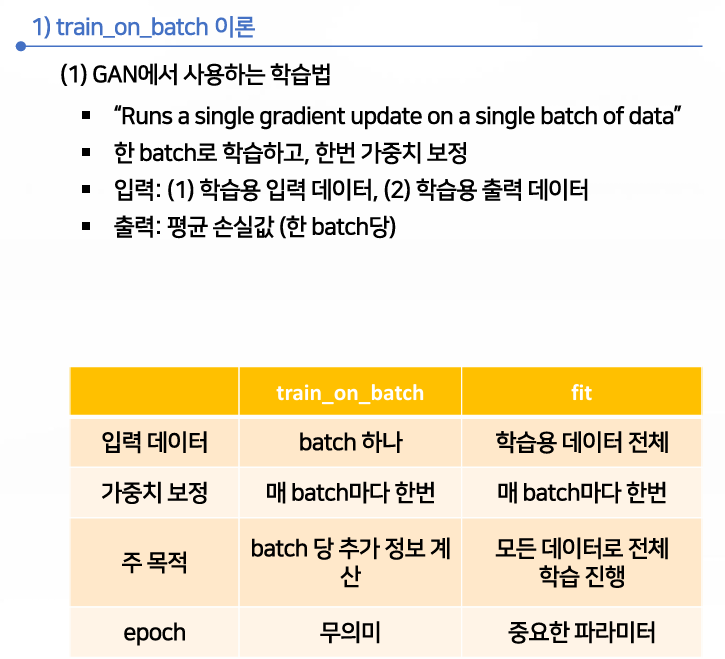

In [21]:
Image("img/day04_17.png", width=400)

In [22]:
# 감별자 학습 방법
def train_discriminator():
    # 진짜 이미지 임의로 한 batch 추출
    total = X_train.shape[0]
    pick = np.random.randint(0, total, MY_BATCH)
    image = X_train[pick]
    
    # 숫자 1로 채워진 batch 생성
    all_1 = np.ones((MY_BATCH, 1))
    
    # 진짜 이미지로 감별자 한번 학습
    d_loss_real = discriminator.train_on_batch(image, all_1)
    
    # 생성자를 이용하여 가짜이미지 todtjd
    # 노이즈 벡터는 표준 정규 분포를 사용
    # 표준 정규 분포란 평균:0, 표준편차 : 1
    noise = np.random.normal(0, 1, (MY_BATCH, MY_NOISE))
    fake = generator.predict(noise)
    
    # 숫자 0로 채워진 batch 생성
    all_0 = np.zeros((MY_BATCH, 1))
    
     # 가짜이미지로 감별자 한번 학습
    d_loss_fake = discriminator.train_on_batch(fake, all_0)
    
    # 평균 손실과 정확도 계산
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    return d_loss
    

In [23]:
# 생성자 학습
def train_generator():
    # 노이즈 벡터는 표준 정규 분포를 사용
    noise = np.random.normal(0,1,(MY_BATCH, MY_NOISE))
    
    # 숫자 1을 한 batch 생성
    all_1 = np.ones((MY_BATCH,1))
    
    # 가짜 이미지로 생성자 한번 학습
    g_loss = gan.train_on_batch(noise, all_1)
    
    return g_loss[0]

In [24]:
# 샘플이미지 출력 ( N * N 출력)
def sample(epoch):
    row = col = 4
    
    # 노이즈 벡터 생성
    noise = np.random.normal(0,1,(row * col , MY_NOISE))
    
    # 생성자를 이용해서 가짜 이미지 생성
    fake = generator.predict(noise)
    
    # 채널 정보 삭제
    fake = np.squeeze(fake)
    
    # 캔버스 만들기
    fig, spot = plt.subplots(row, col)
    
    # i행 j열에 가짜 이미지 추가
    cnt = 0
    for i in range(row):
        for j in range(col):
            spot[i,j].imshow(fake[cnt], cmap ='gray')
            spot[i,j].axis('off')
            cnt += 1
            
    # 이미지를 png 파일로 저장
    path = os.path.join(MY_FOLDER, "img-{}".format(epoch))
    plt.savefig(path)
    plt.close()

In [25]:
## GAN 학습
def train_GAN():
    begin = time()
    
    for epoch in range(MY_EPOCH  + 1):
        d_loss = train_discriminator()
        g_loss = train_generator()
        
        # 50회 반복할 때 마다 
        if epoch % 50 == 0 :
            print("에포크 : ", epoch,
                  "생성자 손실 : {:.3f}".format(g_loss),
                  "감별자 손실 : {:.3f}".format(d_loss[0]),
                  "감별자 정확도 : {:.1f}%".format(d_loss[1]*100)
                 )
            
    end = time()
    
    print("최종 학습 시간 : {.1f}".format(end-begin))


### 컨트롤 타워

In [27]:
# 데이터 준비
X_train = read_data()
discriminator, generator, gan = build_GAN()
#train_GAN()

데이터모양-전 :  (60000, 28, 28)
데이터모양-후 :  (60000, 28, 28, 1)
생성자 요약


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 128)                 │          12,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 784)                 │         101,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,576 (510.06 KB)

 Trainable params: 130,576 (510.06 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,609 (393.00 KB)

 Trainable params: 100,609 (393.00 KB)

 Non-trainable params: 0 (0.00 B)